# Домашнее задание «Модели ARMA»

**Преподаватель:** Даниил Корбут, Наталья Баданина, Елена Харьковская

# Задание

Выберите ряд из первого задания.

Постройте его модель ARIMA.

Оформите отчёт в Jupyter-ноутбук.

Дополнительное задание*

- Попробуйте спрогнозировать график классическим ML.

In [111]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

In [112]:
def test_stationarity(timeseries):
    # Выводим заголовок для результатов теста
    print('Results of Dickey-Fuller Test:')

    # Выполняем тест Дики-Фуллера с автоматическим выбором числа лагов по критерию Акаике (AIC)
    dftest = adfuller(timeseries, autolag='AIC')

    # Создаем серию Pandas, состоящую из первых четырех элементов результатов теста
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    # Добавляем критические значения для различных уровней значимости (1%, 5%, 10%)
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    # Печатаем результаты теста
    print(dfoutput)

In [113]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    # Выполняем тест на стационарность временного ряда
    test_stationarity(y)

    # Преобразуем входные данные в объект Pandas Series, если это не так
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    # Устанавливаем стиль графиков
    with plt.style.context(style):
        # Создаем новую фигуру для графиков, устанавливаем размер
        plt.figure(figsize=figsize)

        # Определяем макет для графиков: 5 строк и 1 столбец
        layout = (5, 1)

        # Создаем оси для различных графиков, используя subplot2grid для точного позиционирования
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)  # График временного ряда
        acf_ax = plt.subplot2grid(layout, (2, 0))             # ACF график
        pacf_ax = plt.subplot2grid(layout, (3, 0))            # PACF график
        qq_ax = plt.subplot2grid(layout, (4, 0))              # QQ график

        # Строим график временного ряда
        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')  # Устанавливаем заголовок для графика временного ряда

        # Строим график автокорреляции
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)

        # Строим график частичной автокорреляции
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        # Строим QQ-график для проверки нормальности распределения
        sm.qqplot(y, line='s', ax=qq_ax)

        # Автоматически подстраиваем размеры графиков
        plt.tight_layout()

    return  # Возврат из функции, без других значений

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


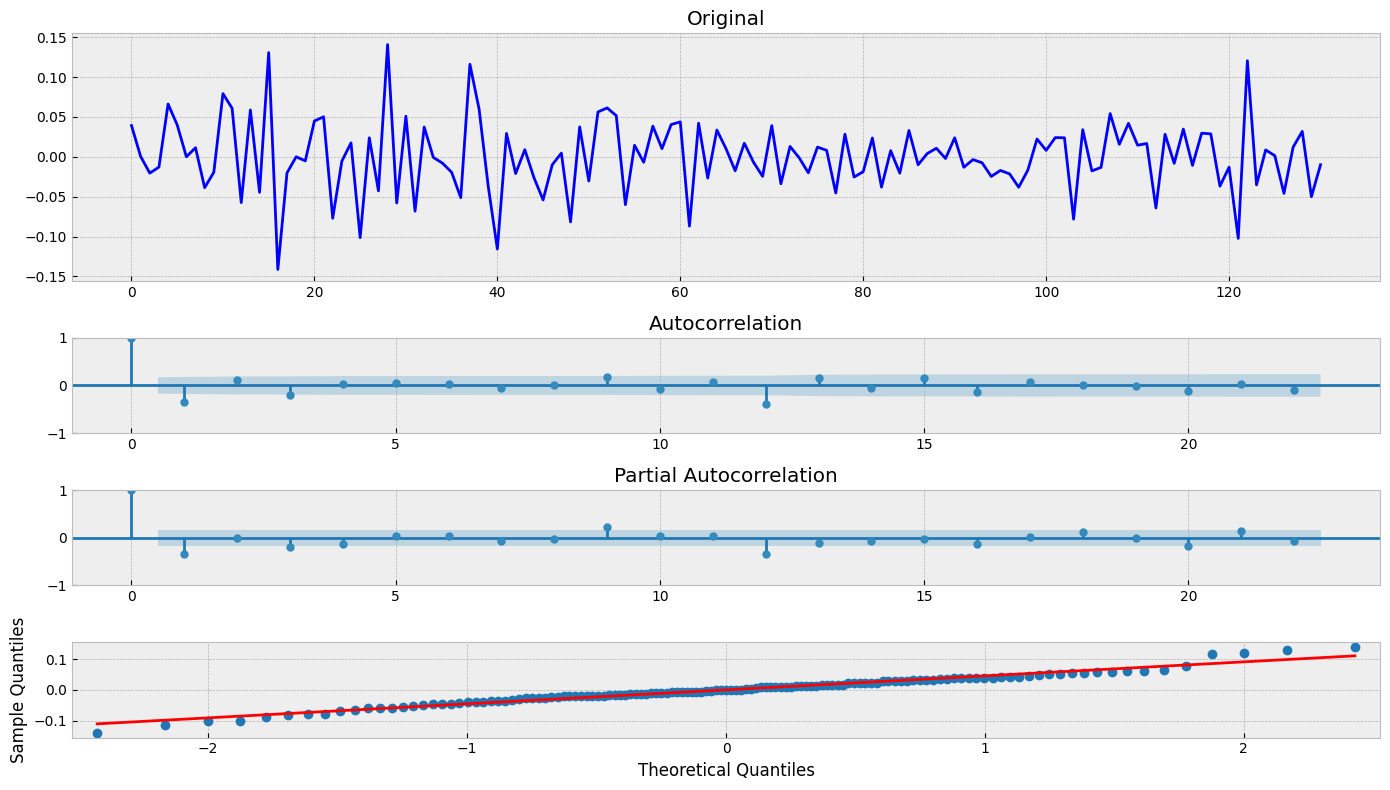

In [114]:
# Считываем данные из CSV файла по указанному URL
series = pd.read_csv("https://raw.githubusercontent.com/stefkong1982/netology.ru/Master/Vremennye_ryady/Znakomstvo_vremennymi_ryadami/Series/international-airline-passengers.csv")['Count']

# Применяем преобразование Бокса-Кокса к временным рядам
series = boxcox(series, 0)

# Вычисляем сезонные различия
seasonal_diff = series[12:] - series[:-12]

# Вычисляем первый порядок разности
first_diff = seasonal_diff[1:] - seasonal_diff[:-1]

# Визуализируем результаты с помощью функции tsplot
tsplot(first_diff)

Ряд стационарен

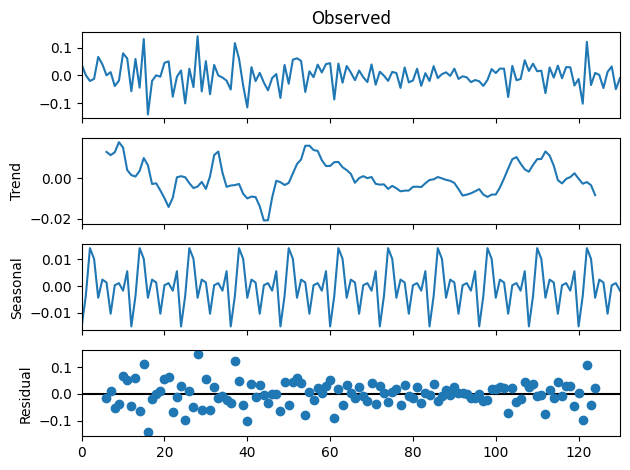

In [115]:
# Декомпозиция временного ряда first_diff
decomposition = seasonal_decompose(first_diff, model='additive', period=12)

# Плотим результаты декомпозиции
fig = decomposition.plot()
plt.show()

Наблюдаем сезонность в стационарном ряде first_diff

На основе результатов теста Дики-Фуллера мы можем сделать вывод, что ваш временной ряд стационарен, поскольку p-value значительно ниже 0.05 и тестовая статистика ниже критических значений при всех уровнях значимости (1%, 5%, 10%). Это означает, что мы, скорее всего, можем продолжить анализ временного ряда, использовав многие методы и модели, учитывающие стационарные данные, такие как ARIMA.

Для построения модели ARIMA нам нужно пройти через несколько этапов, начиная с определения порядка модели ARIMA, который обозначается как ARIMA(p, d, q), где:

- **p** — порядок авторегрессии (количество лагов);
- **d** — порядок интеграции (количество дифференцирований, необходимое для достижения стационарности);
- **q** — порядок скользящей средней (количество лагов остатков).

### 1. Определение порядка интеграции \(d\)

На первом шаге мы уже выполнили первую разность и сезонное различие, поэтому \(d\) равен 1. Это означает, что наш временной ряд уже стал стационарным после того, как мы применили разности.

### 2. Определение порядков \(p\) и \(q\)

Чтобы определить порядки \(p\) и \(q\), мы можем использовать графики ACF (автокорреляционной функции) и PACF (частичной автокорреляционной функции), которые были построены в функции `tsplot`.

### Интерпретация значений ACF и PACF:

1. **ACF**:
   - Значение на 0-лаге всегда равно 1.
   - Значение на 1-лаге -0,3 может указывать на умеренную отрицательную корреляцию, но обычно для выбора \(q\) мы смотрим на значения, где они становятся незначительными. Если значения ACF быстро убывают после первого лага, это говорит о том, что можно использовать мало значимых лагов для \(q\). В вашем случае, так как есть только одно значительное значение (для 1-лага), это может указывать на выбор \(q = 1\).

2. **PACF**:
   - Значение на 0-лаге всегда равно 1, аналогично.
   - Значение на 1-лаге -0,3 также может указывать на умеренную отрицательную автокорреляцию, однако выбор порядка \(p\) обычно основан на значительных значениях. Если PACF также быстро убывает после первого лага, это может означать, что \(p\) тоже равно 1.

### Определение параметров модели ARIMA:

Таким образом, базовая модель ARIMA для вашего временного ряда может быть записана как **ARIMA(1, 1, 1)**.

### Следующий шаг:

Следующим шагом будет создание и оценка модели ARIMA(1, 1, 1).

# Разбиение данных

Размер обучающей выборки: 104
Размер тестовой выборки: 27


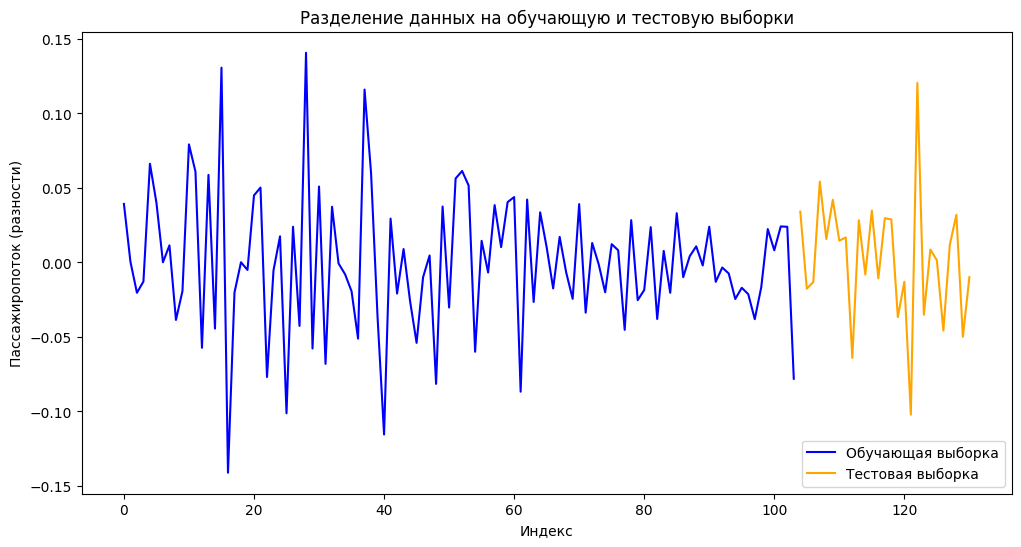

In [116]:
# Общее количество наблюдений
n = len(first_diff)

# Определяем размер обучающей выборки (например, 80% от общего числа наблюдений)
train_size = int(n * 0.8)

# Разделяем данные на обучающую и тестовую выборки
train, test = first_diff[:train_size], first_diff[train_size:]

# Преобразуем массивы back в pandas Series
train_series = pd.Series(train)
test_series = pd.Series(test)

# Выводим размеры обучающей и тестовой выборок
print(f"Размер обучающей выборки: {len(train_series)}")
print(f"Размер тестовой выборки: {len(test_series)}")

# Для наглядности можно построить график
plt.figure(figsize=(12, 6))
plt.plot(train_series.index, train_series, label='Обучающая выборка', color='blue')
plt.plot(test_series.index + train_size, test_series, label='Тестовая выборка', color='orange') # Изменяем индекс тестовой выборки
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.xlabel('Индекс')
plt.ylabel('Пассажиропоток (разности)')
plt.legend()
plt.show()

# Перейдем к построению модели ARIMA

In [117]:
from statsmodels.tsa.arima.model import ARIMA

In [118]:
# Обучите модель ARIMA(1, 1, 1)
model = ARIMA(train_series, order=(1, 1, 1))
model_fit = model.fit()

# Вывод информации о модели
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 172.477
Date:                Sun, 25 Aug 2024   AIC                           -338.954
Time:                        22:20:46   BIC                           -331.050
Sample:                             0   HQIC                          -335.753
                                - 104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3182      0.073     -4.383      0.000      -0.461      -0.176
ma.L1         -1.0000     51.234     -0.020      0.984    -101.416      99.416
sigma2         0.0020      0.100      0.020      0.9

In [119]:
# Прогнозируем следующие значения на основе обученной модели
forecast = model_fit.forecast(steps=len(test_series))

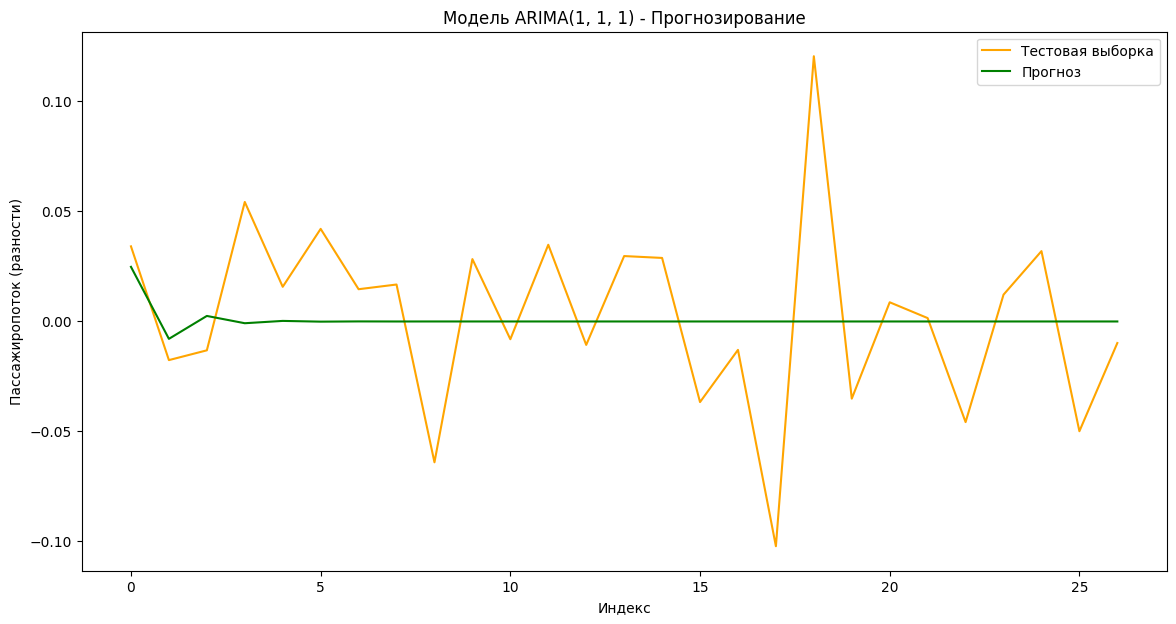

In [120]:
# Построим график прогноза
plt.figure(figsize=(14, 7))
plt.plot(test_series.index, test_series, label='Тестовая выборка', color='orange')
plt.plot(test_series.index, forecast, label='Прогноз', color='green')
plt.title('Модель ARIMA(1, 1, 1) - Прогнозирование')
plt.xlabel('Индекс')
plt.ylabel('Пассажиропоток (разности)')
plt.legend()
plt.show()

In [121]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# Рассчет RMSE
rmse = sqrt(mean_squared_error(test_series, forecast))
print(f'RMSE: {rmse:.2f}')

# Вычисляем R-squared
r_squared = 1 - (mean_squared_error(test_series, forecast) / np.var(test_series))
print(f'R-squared: {r_squared:.2f}')

RMSE: 0.04
R-squared: 0.02


## Вывод по результатам ARIMA



Результаты показали RMSE = 0.04 и R-squared = 0.02. Низкие значения R-squared свидетельствуют о том, что модель ARIMA объясняет всего около 2% вариации в данных. Это может указывать на недостаточность модели в улавливании структуры данных.

# Прогнозирование временного ряда с использованием Random Forest

In [122]:
from sklearn.linear_model import LinearRegression

# Подготовка данных для линейной регрессии
def create_lags(data, lag_count):
    """Создает лаги для временного ряда."""
    # Преобразуем в DataFrame
    df = pd.DataFrame(data)

    # Создание лагов
    for lag in range(1, lag_count + 1):
        df[f'lag_{lag}'] = df[0].shift(lag)

    # Удаляем строки с NaN
    return df.dropna()

# Создание лагов
lags_count = 12  # количество лагов
lagged_data = create_lags(first_diff, lags_count)  # Здесь передаем first_diff, как есть (а не как массив)

# Разделение данных на признаки и целевую переменную
X = lagged_data.drop(columns=[0])  # Признаки (лаговые значения)
y = lagged_data[0]  # Целевая переменная

# Проверим, как это работает
print(X.head())
print("-----------------------")
print(y.head())

       lag_1     lag_2     lag_3     lag_4     lag_5     lag_6     lag_7  \
12  0.060844  0.079150 -0.019418 -0.038715  0.011354  0.000000  0.039915   
13 -0.057448  0.060844  0.079150 -0.019418 -0.038715  0.011354  0.000000   
14  0.058670 -0.057448  0.060844  0.079150 -0.019418 -0.038715  0.011354   
15 -0.044548  0.058670 -0.057448  0.060844  0.079150 -0.019418 -0.038715   
16  0.130705 -0.044548  0.058670 -0.057448  0.060844  0.079150 -0.019418   

       lag_8     lag_9    lag_10    lag_11    lag_12  
12  0.066148 -0.012939 -0.020496  0.000361  0.039164  
13  0.039915  0.066148 -0.012939 -0.020496  0.000361  
14  0.000000  0.039915  0.066148 -0.012939 -0.020496  
15  0.011354  0.000000  0.039915  0.066148 -0.012939  
16 -0.038715  0.011354  0.000000  0.039915  0.066148  
-----------------------
12   -0.057448
13    0.058670
14   -0.044548
15    0.130705
16   -0.141343
Name: 0, dtype: float64


In [123]:
# Разделение данных на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)  # 80% для обучения
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

RMSE (LinearRegression): 0.04
R-squared (LinearRegression): 0.36


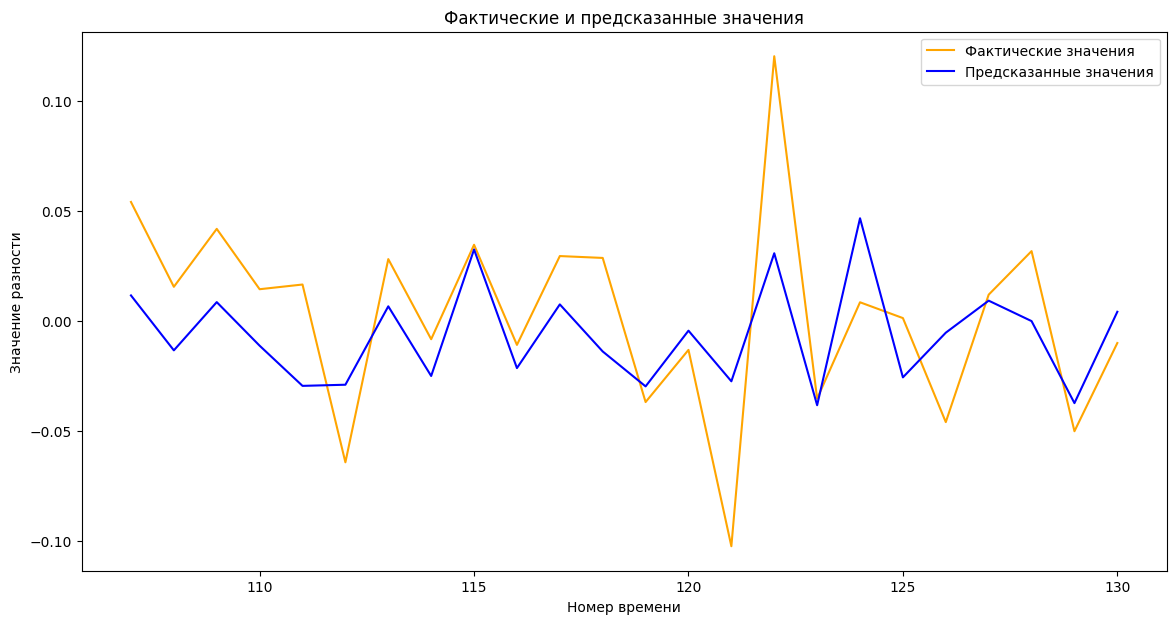

In [124]:
# Обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
from sklearn.metrics import mean_squared_error

# Оценим RMSE
rf_rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE (LinearRegression): {rf_rmse:.2f}')

# Вычисляем R-squared
r_squared = r2_score(y_test, y_pred)
print(f'R-squared (LinearRegression): {r_squared:.2f}')

# Визуализация фактических значений и предсказаний
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Фактические значения', color='orange')
plt.plot(y_test.index, y_pred, label='Предсказанные значения', color='blue')
plt.title('Фактические и предсказанные значения')
plt.xlabel('Номер времени')
plt.ylabel('Значение разности')
plt.legend()
plt.show()

# Вывод по результатам LinearRegression

RMSE для линейной регрессии составил 0.04, а R-squared = 0.36, что указывает на то, что линейная регрессия объясняет 36% вариации в данных. Это более высокая объяснительная способность по сравнению с моделью ARIMA.

# Прогнозирование временного ряда с использованием Random Forest

RMSE (Random Forest): 0.04
R-squared (Random Forest): 0.12


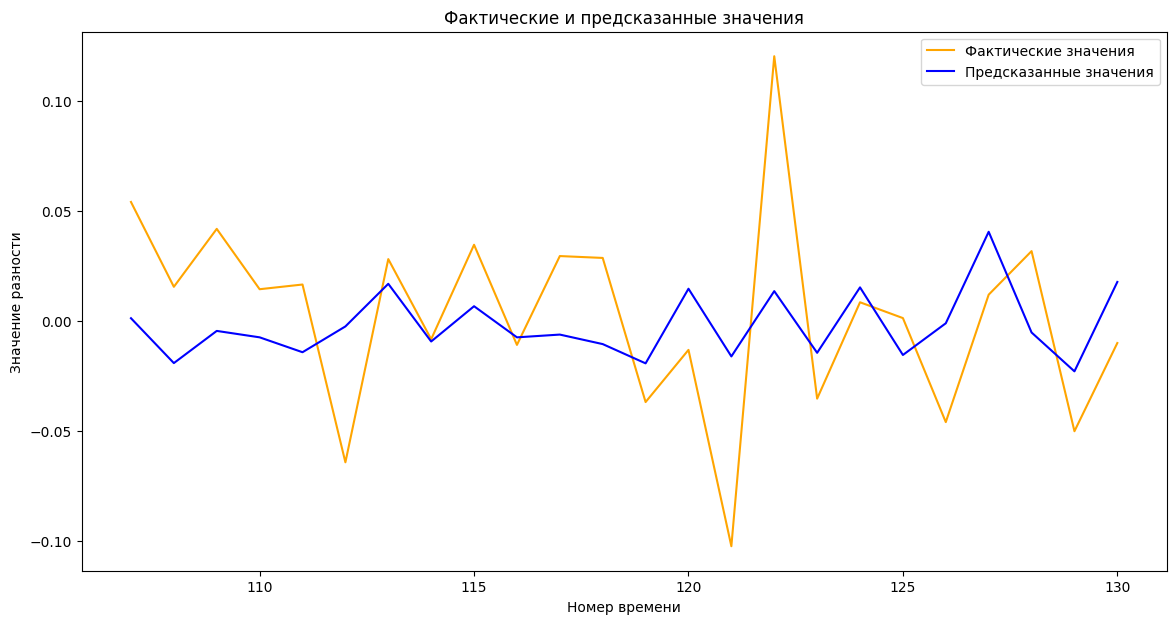

In [125]:
from sklearn.ensemble import RandomForestRegressor

# Обучаем модель Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Делаем прогноз
rf_forecast = rf_model.predict(X_test)

# Оценим RMSE
rf_rmse = sqrt(mean_squared_error(y_test, rf_forecast))
print(f'RMSE (Random Forest): {rf_rmse:.2f}')

# Вычисляем R-squared
r_squared = r2_score(y_test, rf_forecast)
print(f'R-squared (Random Forest): {r_squared:.2f}')

plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Фактические значения', color='orange')
plt.plot(y_test.index, rf_forecast, label='Предсказанные значения', color='blue')
plt.title('Фактические и предсказанные значения')
plt.xlabel('Номер времени')
plt.ylabel('Значение разности')
plt.legend()
plt.show()

# Вывод по результатам


RMSE для Random Forest также составил 0.04, но R-squared = 0.10, что менее эффективно, чем в случае линейной регрессии. Это может означать, что Random Forest не смог улавливать ограничения данных так, как ожидалось, возможно, из-за перерасхода или недостатка решающих деревьев.

### Выводы

На основе представленных моделей можно сделать несколько выводов:

- **Стационарность**: Обнаружение стационарности во временном ряде — ключевой аспект, который позволяет использовать модели, такие как ARIMA.

- **Модель ARIMA**: Несмотря на то, что ARIMA показала неплохие результаты, она не смогла объяснить большую часть варьирования в данных — R-squared был очень низким.

- **Линейная регрессия**: Эта модель показала лучшую объяснительную способность (высокий R-squared), что указывает на наличие влияющих составляющих в лаговых данных.

- **Random Forest**: Эта модель не показала ожидаемых результатов и можливо требует настройки параметров или другой предобработки данных.

### Рекомендации:
**Сезонные велосипеды**: Возможно стоит вернуться к первоначальным данным до применения разностей, чтобы подробнее поработать с их сезонными и трендовыми компонентами.
